In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [2]:
# module for loading and preprocessing LIAR dataset
# arguments:
# train_path, valid_path, test_path - paths to LIAR dataset files
# return - tuple of (train_df, valid_df, test_df) with preprocessed data
def load_liar_dataset(train_path, valid_path, test_path):
    # step 1: define column names for LIAR dataset
    column_names = ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 
                   'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 
                   'mostly_true_counts', 'pants_on_fire_counts', 'context']
    
    # step 2: load datasets
    train_df = pd.read_csv(train_path, sep='\t', names=column_names)
    valid_df = pd.read_csv(valid_path, sep='\t', names=column_names)
    test_df = pd.read_csv(test_path, sep='\t', names=column_names)
    
    # step 3: convert labels to binary (0 for fake, 1 for real)
    # map 'pants-fire', 'false', 'barely-true' to fake (0)
    # map 'half-true', 'mostly-true', 'true' to real (1)
    label_map = {
        'pants-fire': 0, 'false': 0, 'barely-true': 0,
        'half-true': 1, 'mostly-true': 1, 'true': 1
    }
    
    # apply mapping to each dataset
    train_df['label'] = train_df['label'].map(label_map)
    valid_df['label'] = valid_df['label'].map(label_map)
    test_df['label'] = test_df['label'].map(label_map)
    
    # step 4: add source identifier
    train_df['source'] = 'liar'
    valid_df['source'] = 'liar'
    test_df['source'] = 'liar'
    
    return train_df, valid_df, test_df

# module for loading and preprocessing ISOT dataset
# arguments:
# fake_path - path to Fake.csv
# real_path - path to Real.csv
# test_split - fraction of data to use for testing (default: 0.2)
# valid_split - fraction of data to use for validation (default: 0.1)
# return - tuple of (train_df, valid_df, test_df) with preprocessed data
def load_isot_dataset(fake_path, real_path, test_split=0.2, valid_split=0.1):
    # step 1: load fake and real news
    fake_df = pd.read_csv(fake_path)
    real_df = pd.read_csv(real_path)
    
    # step 2: add binary labels (0 for fake, 1 for real)
    fake_df['label'] = 0
    real_df['label'] = 1
    
    # step 3: add source identifier
    fake_df['source'] = 'isot'
    real_df['source'] = 'isot'
    
    # step 4: combine text and title for ISOT dataset
    fake_df['statement'] = fake_df['title'] + " " + fake_df['text'] 
    real_df['statement'] = real_df['title'] + " " + real_df['text']
    
    # step 5: combine datasets
    combined_df = pd.concat([fake_df, real_df], ignore_index=True)
    
    # step 6: shuffle data
    combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # step 7: split into train, validation, and test sets
    test_size = int(len(combined_df) * test_split)
    valid_size = int(len(combined_df) * valid_split)
    
    test_df = combined_df[:test_size]
    valid_df = combined_df[test_size:test_size+valid_size]
    train_df = combined_df[test_size+valid_size:]
    
    return train_df, valid_df, test_df

In [3]:
# function to load, preprocess and combine both datasets
# arguments:
# liar_paths - tuple of (train_path, valid_path, test_path) for LIAR dataset
# isot_paths - tuple of (fake_path, real_path) for ISOT dataset
# return - tuple of (train_df, valid_df, test_df) with combined data
def combine_datasets(liar_paths, isot_paths):
    # step 1: load datasets
    liar_train, liar_valid, liar_test = load_liar_dataset(*liar_paths)
    isot_train, isot_valid, isot_test = load_isot_dataset(*isot_paths)
    
    # step 2: combine datasets
    train_df = pd.concat([liar_train, isot_train], ignore_index=True)
    valid_df = pd.concat([liar_valid, isot_valid], ignore_index=True)
    test_df = pd.concat([liar_test, isot_test], ignore_index=True)
    
    # step 3: shuffle training data
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # step 4: print dataset statistics
    print("Dataset statistics:")
    print(f"  Train set: {len(train_df)} samples")
    print(f"    LIAR: {len(liar_train)} samples")
    print(f"    ISOT: {len(isot_train)} samples")
    print(f"  Validation set: {len(valid_df)} samples")
    print(f"    LIAR: {len(liar_valid)} samples")
    print(f"    ISOT: {len(isot_valid)} samples")
    print(f"  Test set: {len(test_df)} samples")
    print(f"    LIAR: {len(liar_test)} samples")
    print(f"    ISOT: {len(isot_test)} samples")
    
    return train_df, valid_df, test_df

In [4]:
# dataset class that supports source tracking for dataset-aware evaluation
class FakeNewsDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        # step 1: store dataframe and extract necessary columns
        self.df = df
        self.texts = df['statement'].tolist()
        self.labels = df['label'].tolist()
        self.sources = df['source'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        # step 1: get text and label for the index
        text = self.texts[idx]
        label = self.labels[idx]
        
        # step 2: tokenize the text
        encodings = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # step 3: return the encodings and label
        return {
            'input_ids': encodings['input_ids'].squeeze(),
            'attention_mask': encodings['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
    
    # Method to get sources for dataset-aware evaluation
    def get_sources(self):
        return self.sources

In [5]:
# weighted sampler to balance dataset influence during training
# arguments:
# train_df - training dataframe with 'source' column
# return - PyTorch sampler that balances dataset representation
def create_balanced_sampler(train_df):
    # step 1: calculate weights for each sample based on source
    dataset_counts = train_df['source'].value_counts()
    total_samples = len(train_df)
    
    # calculate weights (inverse of dataset frequency)
    weights = []
    for source in train_df['source']:
        source_count = dataset_counts[source]
        # weight = total_samples / (num_datasets * source_count)
        weight = total_samples / (2 * source_count)  # 2 datasets: LIAR and ISOT
        weights.append(weight)
    
    # step 2: create weighted sampler
    weights = torch.FloatTensor(weights)
    sampler = torch.utils.data.WeightedRandomSampler(
        weights=weights,
        num_samples=len(weights),
        replacement=True
    )
    
    return sampler

In [6]:
# calculate class weights for loss function to handle class imbalance
# arguments:
# train_df - training dataframe with 'label' column
# return - class weights tensor for balanced loss calculation
def calculate_class_weights(train_df):
    # step 1: count classes
    class_counts = train_df['label'].value_counts().to_dict()
    total_samples = len(train_df)
    
    # step 2: calculate weights (inverse of class frequency)
    num_classes = len(class_counts)
    weights = []
    
    for class_idx in range(num_classes):
        if class_idx in class_counts:
            weight = total_samples / (num_classes * class_counts[class_idx])
        else:
            weight = 1.0
        weights.append(weight)
    
    # step 3: convert to tensor
    class_weights = torch.FloatTensor(weights)
    return class_weights

In [7]:
# compute metrics for model evaluation
# arguments:
# eval_pred - tuple of (predictions, labels)
# return - dictionary with evaluation metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    return {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions, zero_division=0),
        'recall': recall_score(labels, predictions),
        'f1': f1_score(labels, predictions),
        'roc_auc': roc_auc_score(labels, predictions) if len(np.unique(labels)) > 1 else 0
    }

In [8]:
# hyperparameter tuning with grid search
# arguments:
# model_name - pretrained model name
# train_dataset - dataset for training
# valid_dataset - dataset for validation
# train_sampler - sampler for balanced training
# return - best hyperparameters found
def tune_hyperparameters(model_name, train_dataset, valid_dataset, train_sampler):
    # step 1: define hyperparameter grid
    param_grid = {
        "learning_rate": [1e-5, 2e-5, 3e-5, 5e-5],
        "weight_decay": [0.01, 0.05, 0.1, 0.2],
        "batch_size": [8, 16, 32],
        "epochs": [3, 4, 5]
    }
    
    # step 2: initialize tracking variables
    best_f1 = 0
    best_params = None
    results = []
    
    # step 3: manual grid search (using Trainer for each combination)
    print("Starting hyperparameter tuning...")
    total_combos = (len(param_grid["learning_rate"]) * 
                    len(param_grid["weight_decay"]) * 
                    len(param_grid["batch_size"]) * 
                    len(param_grid["epochs"]))
    
    # To reduce search time, we'll select a smaller subset of combinations
    # This approach tries each parameter while keeping others at default values
    # It's a simplified grid search that's more efficient than testing all combinations
    default_lr = 2e-5
    default_wd = 0.1
    default_bs = 16
    default_epochs = 4
    
    # build combinations list
    combinations = []
    
    # vary learning rate
    for lr in param_grid["learning_rate"]:
        combinations.append({
            "learning_rate": lr,
            "weight_decay": default_wd,
            "batch_size": default_bs,
            "epochs": default_epochs
        })
    
    # vary weight decay
    for wd in param_grid["weight_decay"]:
        if wd != default_wd:  # Skip duplicate of default combo
            combinations.append({
                "learning_rate": default_lr,
                "weight_decay": wd,
                "batch_size": default_bs,
                "epochs": default_epochs
            })
    
    # vary batch size
    for bs in param_grid["batch_size"]:
        if bs != default_bs:  # Skip duplicate of default combo
            combinations.append({
                "learning_rate": default_lr,
                "weight_decay": default_wd,
                "batch_size": bs,
                "epochs": default_epochs
            })
    
    # vary epochs
    for ep in param_grid["epochs"]:
        if ep != default_epochs:  # Skip duplicate of default combo
            combinations.append({
                "learning_rate": default_lr,
                "weight_decay": default_wd,
                "batch_size": default_bs,
                "epochs": ep
            })
    
    print(f"Testing {len(combinations)} hyperparameter combinations instead of {total_combos}")
    
    # run grid search
    for i, params in enumerate(combinations):
        print(f"\nTrying combination {i+1}/{len(combinations)}:")
        print(f"  Learning rate: {params['learning_rate']}")
        print(f"  Weight decay: {params['weight_decay']}")
        print(f"  Batch size: {params['batch_size']}")
        print(f"  Epochs: {params['epochs']}")
        
        # Create a temporary output directory
        output_dir = f"./hp_tuning_{i}"
        os.makedirs(output_dir, exist_ok=True)
        
        # Create training arguments
        training_args = TrainingArguments(
            output_dir=output_dir,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            learning_rate=params["learning_rate"],
            per_device_train_batch_size=params["batch_size"],
            per_device_eval_batch_size=params["batch_size"],
            num_train_epochs=params["epochs"],
            weight_decay=params["weight_decay"],
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            push_to_hub=False,
            report_to="none",
            logging_steps=500,
            disable_tqdm=False
        )
        
        # Initialize model
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=2
        )
        
        # Create trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=valid_dataset,
            compute_metrics=compute_metrics
        )
        
        # Override the get_train_dataloader method to use our balanced loader
        if train_sampler is not None:
            train_dataloader = DataLoader(
                train_dataset,
                batch_size=params["batch_size"],
                sampler=train_sampler
            )
            original_get_train_dataloader = trainer.get_train_dataloader
            trainer.get_train_dataloader = lambda: train_dataloader
        
        # Train model
        trainer.train()
        
        # Restore original dataloader method if modified
        if train_sampler is not None:
            trainer.get_train_dataloader = original_get_train_dataloader
        
        # Evaluate
        eval_result = trainer.evaluate()
        f1_score = eval_result["eval_f1"]
        
        # Track results
        results.append({
            "params": params,
            "f1": f1_score,
            "eval_results": eval_result
        })
        
        print(f"  F1 Score: {f1_score:.4f}")
        
        # Update best parameters if we found a better F1 score
        if f1_score > best_f1:
            best_f1 = f1_score
            best_params = params
            print(f"  New best F1 score: {best_f1:.4f}")
    
    # step 4: display and return best results
    print("\nHyperparameter tuning complete!")
    print(f"Best F1 score: {best_f1:.4f}")
    print(f"Best parameters: {best_params}")
    
    # display all results sorted by F1 score
    print("\nAll Results (sorted by F1 score):")
    for res in sorted(results, key=lambda x: x["f1"], reverse=True):
        print(f"F1: {res['f1']:.4f}, Params: {res['params']}")
    
    return best_params

In [9]:
# function to evaluate model with dataset awareness
# arguments:
# trainer - Trainer instance
# test_dataset - dataset to evaluate on
# return - dictionary with evaluation metrics
def evaluate_dataset_aware(trainer, test_dataset):
    # step 1: get overall metrics using trainer
    test_results = trainer.evaluate(test_dataset)
    
    # step 2: get dataset-specific metrics
    # get predictions
    test_predictions = trainer.predict(test_dataset)
    predictions = np.argmax(test_predictions.predictions, axis=1)
    true_labels = test_predictions.label_ids
    sources = test_dataset.get_sources()
    
    # step 3: convert results to a more readable format
    readable_results = {}
    for key, value in test_results.items():
        # Extract the actual metric name from keys like 'eval_accuracy'
        if key.startswith('eval_'):
            metric_name = key[5:]  # Remove 'eval_' prefix
            readable_results[metric_name] = round(value, 4)  # Round to 4 decimal places
        else:
            readable_results[key] = value
    
    # step 4: calculate dataset-specific metrics
    dataset_metrics = {'overall': readable_results}
    
    for source in set(sources):
        # Get indices for this source
        source_indices = [i for i, s in enumerate(sources) if s == source]
        source_preds = [predictions[i] for i in source_indices]
        source_labels = [true_labels[i] for i in source_indices]
        
        # Calculate metrics for this source
        if len(source_indices) > 0 and len(set(source_labels)) > 1:
            source_metrics = {
                'accuracy': round(accuracy_score(source_labels, source_preds), 4),
                'precision': round(precision_score(source_labels, source_preds, zero_division=0), 4),
                'recall': round(recall_score(source_labels, source_preds), 4),
                'f1': round(f1_score(source_labels, source_preds), 4),
                'roc_auc': round(roc_auc_score(source_labels, source_preds), 4) if len(set(source_labels)) > 1 else 0
            }
            dataset_metrics[source] = source_metrics
    
    # step 5: display overall metrics table
    overall_metrics = pd.DataFrame({
        'Metric': list(readable_results.keys()),
        'Value': list(readable_results.values())
    })
    print("\nOverall Performance Metrics:")
    print(overall_metrics.set_index('Metric').transpose())
    
    # step 6: display source-specific metrics
    for source in dataset_metrics.keys():
        if source != 'overall':
            source_df = pd.DataFrame({
                'Metric': list(dataset_metrics[source].keys()),
                'Value': list(dataset_metrics[source].values())
            })
            print(f"\n{source.upper()} Dataset Performance Metrics:")
            print(source_df.set_index('Metric').transpose())
    
    # step 7: create overall confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"]).plot(cmap="Blues")
    plt.title("Overall Fake News Detection Confusion Matrix")
    plt.tight_layout()
    plt.show()
    
    # step 8: create source-specific confusion matrices
    for source in set(sources):
        source_indices = [i for i, s in enumerate(sources) if s == source]
        if len(source_indices) > 0:
            source_preds = [predictions[i] for i in source_indices]
            source_labels = [true_labels[i] for i in source_indices]
            
            cm = confusion_matrix(source_labels, source_preds)
            plt.figure(figsize=(8, 6))
            ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"]).plot(cmap="Blues")
            plt.title(f"{source.upper()} Dataset Fake News Detection Confusion Matrix")
            plt.tight_layout()
            plt.show()
    
    return dataset_metrics

In [10]:
# main function to run the pipeline with dataset balancing and hyperparameter tuning
def run_balanced_fake_news_pipeline():
    # step 1: define paths
    liar_paths = (
        "data/liar_dataset/train.tsv",  # LIAR train path
        "data/liar_dataset/valid.tsv",  # LIAR validation path
        "data/liar_dataset/test.tsv"    # LIAR test path
    )
    
    isot_paths = (
        "data/isot_dataset/Fake.csv",   # ISOT fake news path
        "data/isot_dataset/True.csv"    # ISOT real news path
    )
    
    # step 2: load and combine datasets
    train_df, valid_df, test_df = combine_datasets(liar_paths, isot_paths)
    
    # step 3: initialize tokenizer
    model_name = "google/mobilebert-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # step 4: create datasets
    train_dataset = FakeNewsDataset(train_df, tokenizer)
    valid_dataset = FakeNewsDataset(valid_df, tokenizer)
    test_dataset = FakeNewsDataset(test_df, tokenizer)
    
    # step 5: create balanced sampler for training
    print("\nCreating balanced dataset sampler...")
    balanced_sampler = create_balanced_sampler(train_df)
    
    # step 6: perform hyperparameter tuning
    best_hparams = tune_hyperparameters(model_name, train_dataset, valid_dataset, balanced_sampler)
    
    # step 7: train final model with optimal hyperparameters
    print("\nTraining final model with optimal hyperparameters...")
    
    # configure training with optimal hyperparameters
    training_args = TrainingArguments(
        output_dir="./balanced_model",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=best_hparams["learning_rate"],
        per_device_train_batch_size=best_hparams["batch_size"],
        per_device_eval_batch_size=best_hparams["batch_size"],
        num_train_epochs=best_hparams["epochs"],
        weight_decay=best_hparams["weight_decay"],
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        push_to_hub=False,
        report_to="none",
    )
    
    # initialize model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=2
    )
    
    # set up early stopping
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=2,
        early_stopping_threshold=0.001
    )
    
    # initialize Trainer for final training
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping_callback]
    )
    
    # use balanced sampler for final training
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=best_hparams["batch_size"],
        sampler=balanced_sampler
    )
    
    # override the get_train_dataloader method to use our balanced loader
    original_get_train_dataloader = trainer.get_train_dataloader
    trainer.get_train_dataloader = lambda: train_dataloader
    
    # train the model
    trainer.train()
    
    # restore original dataloader method
    trainer.get_train_dataloader = original_get_train_dataloader
    
    # step 8: evaluate with dataset awareness
    print("\nEvaluating final model...")
    dataset_metrics = evaluate_dataset_aware(trainer, test_dataset)
    
    # step 9: save model
    model_path = "balanced_fake_news_model_final"
    trainer.save_model(model_path)
    tokenizer.save_pretrained(model_path)
    print(f"\nModel and tokenizer saved to {model_path}")
    
    return trainer, dataset_metrics, best_hparams

Dataset statistics:
  Train set: 41670 samples
    LIAR: 10240 samples
    ISOT: 31430 samples
  Validation set: 5773 samples
    LIAR: 1284 samples
    ISOT: 4489 samples
  Test set: 10246 samples
    LIAR: 1267 samples
    ISOT: 8979 samples

Creating balanced dataset sampler...
Starting hyperparameter tuning...
Testing 11 hyperparameter combinations instead of 144

Trying combination 1/11:
  Learning rate: 1e-05
  Weight decay: 0.1
  Batch size: 16
  Epochs: 4


C:\Users\Gabriel\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,2466.217300,276.600342,0.857093,0.998485,0.706324,0.827370,0.852657
2,8.536100,3.574726,0.526763,0.506446,0.940336,0.658329,0.538931
3,0.412600,0.391899,0.906288,0.855703,0.970347,0.909426,0.908173
4,0.334300,0.267923,0.908540,0.877368,0.943194,0.909091,0.909559


  F1 Score: 0.9094
  New best F1 score: 0.9094

Trying combination 2/11:
  Learning rate: 2e-05
  Weight decay: 0.1
  Batch size: 16
  Epochs: 4


C:\Users\Gabriel\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.312000,0.169905,0.906808,0.864560,0.957842,0.908814,0.908309
2,0.259300,0.184365,0.913563,0.894376,0.931761,0.912686,0.914099
3,0.189900,0.246792,0.911658,0.887572,0.936406,0.911335,0.912386
4,0.267600,0.272393,0.912351,0.896576,0.926045,0.911072,0.912754


  F1 Score: 0.9127
  New best F1 score: 0.9127

Trying combination 3/11:
  Learning rate: 3e-05
  Weight decay: 0.1
  Batch size: 16
  Epochs: 4


C:\Users\Gabriel\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.298000,0.213376,0.906808,0.857866,0.968203,0.909701,0.908614
2,0.235200,0.240117,0.912351,0.901014,0.920329,0.910569,0.912585
3,0.161000,0.365724,0.908367,0.887372,0.928903,0.907663,0.908971
4,0.091600,0.486225,0.909752,0.893845,0.923544,0.908452,0.910158


  F1 Score: 0.9106

Trying combination 4/11:
  Learning rate: 5e-05
  Weight decay: 0.1
  Batch size: 16
  Epochs: 4


C:\Users\Gabriel\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.340500,0.187931,0.906808,0.860147,0.964630,0.909397,0.908509
2,0.185800,0.278829,0.910272,0.898916,0.918185,0.908448,0.910505
3,0.104600,0.505874,0.909752,0.896588,0.919971,0.908129,0.910053
4,0.050200,0.656484,0.907154,0.894388,0.916756,0.905434,0.907436


  F1 Score: 0.9094

Trying combination 5/11:
  Learning rate: 2e-05
  Weight decay: 0.01
  Batch size: 16
  Epochs: 4


C:\Users\Gabriel\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.304500,0.180535,0.902823,0.853220,0.965702,0.905983,0.904673
2,0.252300,0.186141,0.914602,0.896492,0.931404,0.913615,0.915097
3,0.198200,0.234271,0.911658,0.892086,0.930332,0.910808,0.912207
4,0.155100,0.255322,0.911484,0.900560,0.918900,0.909637,0.911703


  F1 Score: 0.9136
  New best F1 score: 0.9136

Trying combination 6/11:
  Learning rate: 2e-05
  Weight decay: 0.05
  Batch size: 16
  Epochs: 4


C:\Users\Gabriel\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.307700,0.170086,0.909233,0.866109,0.961415,0.911277,0.910768
2,0.255000,0.188364,0.917374,0.893559,0.941765,0.917029,0.918092
3,0.197700,0.239377,0.913217,0.896480,0.928189,0.912059,0.913657
4,0.155300,0.263501,0.914083,0.900522,0.924973,0.912584,0.914403


  F1 Score: 0.9170
  New best F1 score: 0.9170

Trying combination 7/11:
  Learning rate: 2e-05
  Weight decay: 0.2
  Batch size: 16
  Epochs: 4


C:\Users\Gabriel\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.308900,0.170223,0.905768,0.858506,0.964630,0.908479,0.907500
2,0.254400,0.185294,0.913390,0.885350,0.943551,0.913525,0.914277
3,0.275900,0.232573,0.912351,0.886678,0.939264,0.912214,0.913142
4,0.156300,0.259472,0.914256,0.895062,0.932476,0.913386,0.914792


  F1 Score: 0.9135

Trying combination 8/11:
  Learning rate: 2e-05
  Weight decay: 0.1
  Batch size: 8
  Epochs: 4


C:\Users\Gabriel\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.716000,0.193020,0.907327,0.865397,0.957842,0.909276,0.908813
2,0.300700,0.281068,0.915988,0.918596,0.907110,0.912817,0.915727
3,0.229300,0.443647,0.910099,0.890411,0.928903,0.909250,0.910652
4,0.171700,0.515791,0.909059,0.896444,0.918542,0.907358,0.909338


  F1 Score: 0.9128

Trying combination 9/11:
  Learning rate: 2e-05
  Weight decay: 0.1
  Batch size: 32
  Epochs: 4


C:\Users\Gabriel\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.328700,0.157233,0.912697,0.870999,0.962487,0.914460,0.914162
2,0.285300,0.168102,0.911831,0.872964,0.957485,0.913273,0.913174
3,0.258400,0.170368,0.913563,0.897649,0.927474,0.912318,0.913972
4,0.221600,0.179562,0.912697,0.893924,0.930332,0.911765,0.913216


  F1 Score: 0.9145

Trying combination 10/11:
  Learning rate: 2e-05
  Weight decay: 0.1
  Batch size: 16
  Epochs: 3


C:\Users\Gabriel\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,4.039600,0.170742,0.905249,0.865110,0.953198,0.907020,0.906659
2,0.267100,0.185694,0.914949,0.885438,0.947124,0.915243,0.915896
3,0.222500,0.199506,0.910965,0.900737,0.917471,0.909027,0.911156


  F1 Score: 0.9152

Trying combination 11/11:
  Learning rate: 2e-05
  Weight decay: 0.1
  Batch size: 16
  Epochs: 5


C:\Users\Gabriel\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.378100,0.182594,0.906115,0.856782,0.968203,0.909091,0.907941
2,0.467800,0.495290,0.913563,0.880543,0.950697,0.914276,0.914656
3,0.249900,0.268075,0.909233,0.890491,0.926760,0.908263,0.909748
4,0.136800,0.401198,0.910618,0.887870,0.933548,0.910136,0.911293
5,0.111000,0.469515,0.912870,0.894502,0.929975,0.911894,0.913374


  F1 Score: 0.9143

Hyperparameter tuning complete!
Best F1 score: 0.9170
Best parameters: {'learning_rate': 2e-05, 'weight_decay': 0.05, 'batch_size': 16, 'epochs': 4}

All Results (sorted by F1 score):
F1: 0.9170, Params: {'learning_rate': 2e-05, 'weight_decay': 0.05, 'batch_size': 16, 'epochs': 4}
F1: 0.9152, Params: {'learning_rate': 2e-05, 'weight_decay': 0.1, 'batch_size': 16, 'epochs': 3}
F1: 0.9145, Params: {'learning_rate': 2e-05, 'weight_decay': 0.1, 'batch_size': 32, 'epochs': 4}
F1: 0.9143, Params: {'learning_rate': 2e-05, 'weight_decay': 0.1, 'batch_size': 16, 'epochs': 5}
F1: 0.9136, Params: {'learning_rate': 2e-05, 'weight_decay': 0.01, 'batch_size': 16, 'epochs': 4}
F1: 0.9135, Params: {'learning_rate': 2e-05, 'weight_decay': 0.2, 'batch_size': 16, 'epochs': 4}
F1: 0.9128, Params: {'learning_rate': 2e-05, 'weight_decay': 0.1, 'batch_size': 8, 'epochs': 4}
F1: 0.9127, Params: {'learning_rate': 2e-05, 'weight_decay': 0.1, 'batch_size': 16, 'epochs': 4}
F1: 0.9106, Params:

C:\Users\Gabriel\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.306400,0.177676,0.907847,0.856111,0.973562,0.911067,0.909780
2,0.245900,0.185932,0.912697,0.891772,0.933190,0.912011,0.913300
3,0.180800,0.244151,0.910272,0.898080,0.919257,0.908545,0.910536



Evaluating final model...



Overall Performance Metrics:
Metric    loss  accuracy  precision  recall      f1  roc_auc  runtime  \
Value   0.1009    0.9525     0.9424  0.9605  0.9514   0.9527   59.874   

Metric  samples_per_second  steps_per_second  epoch  
Value              171.126            10.706    3.0  

ISOT Dataset Performance Metrics:
Metric  accuracy  precision  recall      f1  roc_auc
Value     0.9987     0.9974  0.9998  0.9986   0.9987

LIAR Dataset Performance Metrics:
Metric  accuracy  precision  recall      f1  roc_auc
Value     0.6251     0.6496  0.7269  0.6861   0.6103


<Figure size 800x600 with 0 Axes>

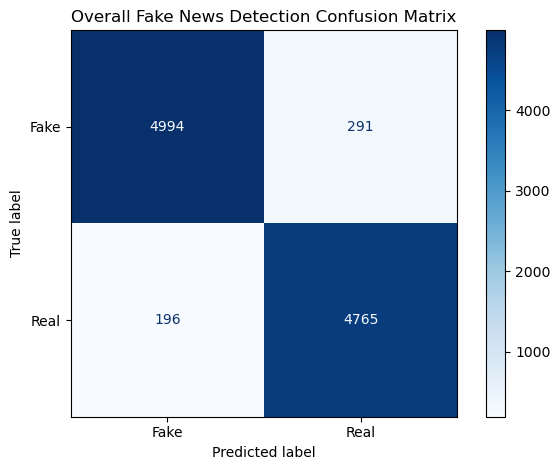

<Figure size 800x600 with 0 Axes>

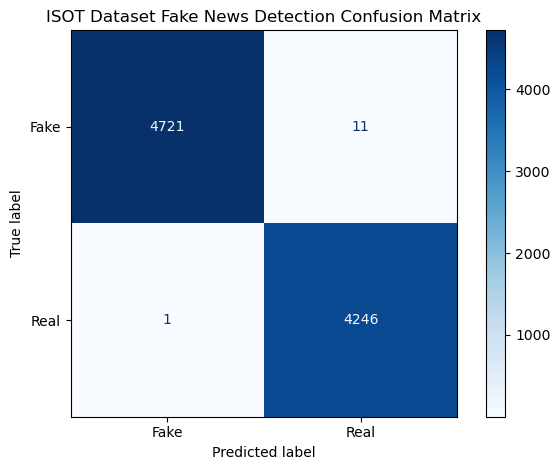

<Figure size 800x600 with 0 Axes>

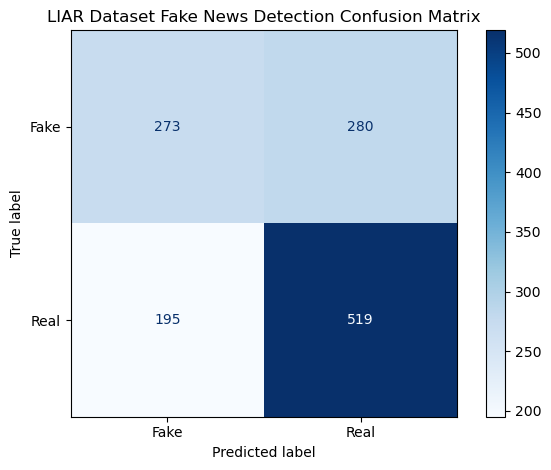


Model and tokenizer saved to balanced_fake_news_model_final


In [11]:
# run the pipeline 
if __name__ == "__main__":
    run_balanced_fake_news_pipeline()